# Prédire les habitudes de consommation d'alcool des adolescents

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
student = pd.read_csv("https://raw.githubusercontent.com/udacity/machine-learning/master/projects/student_intervention/student-data.csv", sep=",").dropna()
student.rename(columns={'sex':'gender'}, inplace=True)
student['alcohol_index'] = (5*student['Dalc'] + 2*student['Walc'])/7
# Niveau de consommation d'alcool
student['acl'] = student['alcohol_index'] <= 2
student['acl'] = student['acl'].map({True: 'Low', False: 'High'})

In [3]:
student.head(3)

,school,gender,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,passed,alcohol_index,acl
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,no,1.000000,Low
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,no,1.000000,Low
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,yes,2.285714,High


In [4]:
student.shape

(395, 33)

In [5]:
student.dtypes

school            object
gender            object
age                int64
address           object
famsize           object
Pstatus           object
Medu               int64
Fedu               int64
Mjob              object
Fjob              object
reason            object
guardian          object
traveltime         int64
studytime          int64
failures           int64
schoolsup         object
famsup            object
paid              object
activities        object
nursery           object
higher            object
internet          object
romantic          object
famrel             int64
freetime           int64
goout              int64
Dalc               int64
Walc               int64
health             int64
absences           int64
passed            object
alcohol_index    float64
acl               object
dtype: object

In [6]:
student.columns

Index(['school', 'gender', 'age', 'address', 'famsize', 'Pstatus', 'Medu',
       'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'passed', 'alcohol_index', 'acl'],
      dtype='object')

student's home address type (binary: 'U' - urban or 'R' - rural) 
Family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
PSTATUS Parent's cohabitation status (binary: 'T' - living together or 'A' - living apart)
FEDU MEDU Mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education, or 4 - higher education)
MJOB FJOB Mother's job (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
REASON Reason to choose this school (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
GUARDIAN Student's guardian (nominal: 'mother', 'father' or 'other')
TRAVELTIME Home to school travel time (numeric: 1 - &lt;15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - &gt;1 hour)
STUDYTIME Weekly study time (numeric: 1 - &lt;2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - &gt;10 hours)
failures           Number of past class failures (numeric: n if 1&lt;=n&lt;3, else 4)
SCHOOLSUP Extra educational support (binary: yes or no)
FAMSUP Family educational support (binary: yes or no)
PAID Extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
ACTIVITIES Extra-curricular activities (binary: yes or no) 
NURSERY  Attended nursery school (binary: yes or no)
HIGHER Wants to take higher education (binary: yes or no)
INTERNET  Internet access at home (binary: yes or no)
ROMANTIC With a romantic relationship (binary: yes or no)
FAMREL Quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
FREETIME free time after school (numeric: from 1 - very low to 5 - very high)
GOOUT Going out with friends (numeric: from 1 - very low to 5 - very high)
HEALTH Current health status (numeric: from 1 - very bad to 5 - very good)

In [7]:
features = ['school', 'gender', 'age', 'address', 'famsize', 'Pstatus', 'Medu',
       'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout','health' ]

In [8]:
# on garde certaines variables socio démo (suppression des variables de conso dalcool et de scolarité)
#features = ['school','gender','famsize','age','Pstatus','Medu',"Fedu","Mjob","Fjob",'studytime','famrel','goout','freetime','G3']

In [9]:
student[features].describe(include='all')

,school,gender,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health
count,395,395,395.000000,395,395,395,395.000000,395.000000,395,395,...,395,395,395,395,395,395,395.000000,395.000000,395.000000,395.000000
unique,2,2,NaN,2,2,2,NaN,NaN,5,5,...,2,2,2,2,2,2,NaN,NaN,NaN,NaN
top,GP,F,NaN,U,GT3,T,NaN,NaN,other,other,...,no,yes,yes,yes,yes,no,NaN,NaN,NaN,NaN
freq,349,208,NaN,307,281,354,NaN,NaN,141,217,...,214,201,314,375,329,263,NaN,NaN,NaN,NaN
mean,NaN,NaN,16.696203,NaN,NaN,NaN,2.749367,2.521519,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.944304,3.235443,3.108861,3.554430
std,NaN,NaN,1.276043,NaN,NaN,NaN,1.094735,1.088201,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.896659,0.998862,1.113278,1.390303
min,NaN,NaN,15.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000
25%,NaN,NaN,16.000000,NaN,NaN,NaN,2.000000,2.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,3.000000,2.000000,3.000000
50%,NaN,NaN,17.000000,NaN,NaN,NaN,3.000000,2.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,3.000000,3.000000,4.000000
75%,NaN,NaN,18.000000,NaN,NaN,NaN,4.000000,3.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,4.000000,4.000000,5.000000


In [10]:
featuresquali = ['school','gender','famsize','address','Pstatus','Mjob','Fjob','reason','guardian','schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic']
student[featuresquali].describe(include='all')

,school,gender,famsize,address,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395,395
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,GT3,U,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,349,208,281,307,354,141,217,145,273,344,242,214,201,314,375,329,263


In [11]:
featuresquanti = ['age', 'Medu','Fedu',  'traveltime', 'studytime',
       'failures',  'famrel', 'freetime', 'goout','health']
target = 'acl'

## Préparation de l'apprentissage

### Important: Scikit-learn ne comprend que les chiffres!

C'est pourquoi nous devons créer ce qu'on appelle "dummy" features ou one-hot encoded features.

In [12]:
# For gender: Female will be 0, Male will be 1
#student['gender'] = student['gender'].map({'F':0, 'M':1}).astype(int)
# For famsize: 'LE3' - less or equal to 3 will be 0. 'GT3' - greater than 3 will be one
#student['famsize'] = student['famsize'].map({'LE3':0, 'GT3':1}).astype(int)
# for acl: 'Low' will be 0, 'High' will be 1
student['acl'] = student['acl'].map({'Low':0, 'High':1}).astype(int)

In [13]:
student['acl'].head()

0    0
1    0
2    1
3    0
4    0
Name: acl, dtype: int64

In [14]:
#pd.get_dummies(pd.Series(list('bcaa')), drop_first=True)

In [15]:
# ca va plus vite avec get dummies
dummies_nb = pd.get_dummies(student[featuresquali], drop_first=True)
# on réunit les var quanti et les dummies
studentPrep = pd.concat([student[featuresquanti], dummies_nb], axis=1)

In [16]:
X = studentPrep
y = student[target]

In [17]:
y.head()

0    0
1    0
2    1
3    0
4    0
Name: acl, dtype: int64

### étude de la variable cible

In [18]:
y.value_counts(normalize=True)

0    0.736709
1    0.263291
Name: acl, dtype: float64

In [19]:
y.mean()

0.26329113924050634

In [20]:
y.describe()

count    395.000000
mean       0.263291
std        0.440978
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: acl, dtype: float64

### Modèle avec Cross Validation pour éviter de faire un éch test

L'arbre de décision est un modèle de classification qui va découper la population en feuilles les plus pures possible en event 1 ou 0

In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection

In [22]:
modele_arbre=DecisionTreeClassifier(random_state = 2016, max_depth = 3, min_samples_leaf = 30)

On fait un modèle avec de la cross validation et pas d'éch test

In [23]:
modele_arbreCV = model_selection.cross_validate(
                                        modele_arbre,
                                        X,
                                        y,
                                        scoring='roc_auc',
                                        cv=4,
                                        return_train_score=True)

In [24]:
# calcule la métrique pour chaque fold 
print(modele_arbreCV['train_score'],modele_arbreCV['test_score'])
# on voit une grosse perte en généralisation

[0.77152435 0.7609386  0.75520466 0.77801194] [0.68282403 0.70679663 0.71944152 0.62232906]


In [25]:
modele_arbreCV['train_score'].mean() - modele_arbreCV['test_score'].mean()

0.08357207987054349

### Modèle avec Partition train /  test

In [26]:
# split Apprentissage Test
from sklearn.model_selection import train_test_split 

In [27]:
# Application de la fonction avec tirage de 30% en test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

max depth et min samples leaf sont des hyper paramètres

In [28]:
modele_arbre1 = DecisionTreeClassifier(random_state = 2016, max_depth = 4, min_samples_leaf = 20)

In [29]:
modele_arbre1.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2016, splitter='best')

[Text(472.15384615384613, 978.48, 'X[8] <= 3.5\ngini = 0.392\nsamples = 100.0%\nvalue = [0.732, 0.268]\nclass = y[0]'),
 Text(171.69230769230768, 761.0400000000001, 'X[32] <= 0.5\ngini = 0.231\nsamples = 62.7%\nvalue = [0.867, 0.133]\nclass = y[0]'),
 Text(85.84615384615384, 543.6, 'gini = 0.426\nsamples = 14.1%\nvalue = [0.692, 0.308]\nclass = y[0]'),
 Text(257.53846153846155, 543.6, 'X[16] <= 0.5\ngini = 0.151\nsamples = 48.6%\nvalue = [0.918, 0.082]\nclass = y[0]'),
 Text(171.69230769230768, 326.1600000000001, 'X[0] <= 15.5\ngini = 0.079\nsamples = 35.1%\nvalue = [0.959, 0.041]\nclass = y[0]'),
 Text(85.84615384615384, 108.72000000000003, 'gini = 0.18\nsamples = 10.9%\nvalue = [0.9, 0.1]\nclass = y[0]'),
 Text(257.53846153846155, 108.72000000000003, 'gini = 0.029\nsamples = 24.3%\nvalue = [0.985, 0.015]\nclass = y[0]'),
 Text(343.38461538461536, 326.1600000000001, 'gini = 0.307\nsamples = 13.4%\nvalue = [0.811, 0.189]\nclass = y[0]'),
 Text(772.6153846153845, 761.0400000000001, 'X[1

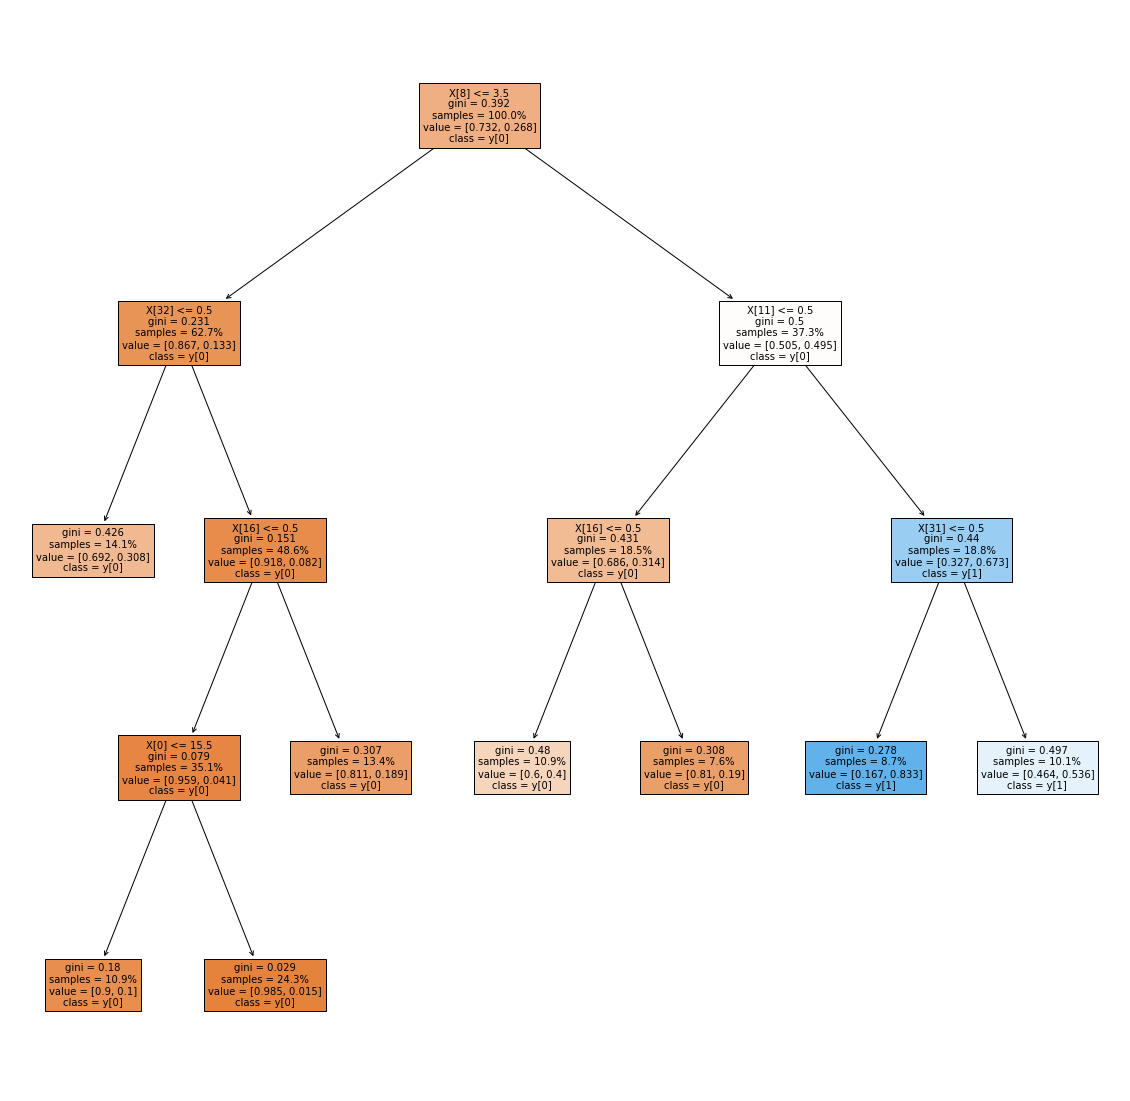

In [30]:
from sklearn import tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 20))
tree.plot_tree(modele_arbre1,class_names=True, max_depth=4,proportion=True, fontsize=10,filled=True) 

### On va balayer une grille d'hyper paramètres avec la cross validation

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
# La grille
param = [{ "max_depth": [2,3,4,5],  "min_samples_leaf": [20,30,40,50]}]

# on declare le modele DecisionTreeClassifier sur lequel par cross validation on va balayer la grille
#tree= GridSearchCV(DecisionTreeClassifier(), param, cv = 4, n_jobs = -1, scoring='roc_auc')
modelCV= GridSearchCV(DecisionTreeClassifier(), param, cv = 4, n_jobs = -1, scoring='neg_log_loss')

modelCV = modelCV.fit(X_train, y_train)

In [33]:
# Les meilleurs paramètres sont selon la métrique :
modelCV.best_params_

{'max_depth': 2, 'min_samples_leaf': 30}

### nouveau modèle avec la meilleure grille

In [34]:
# On relance le modèle
modele_arbre2 = DecisionTreeClassifier(random_state = 2016, max_depth = 2, min_samples_leaf = 30)
modele_arbre2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=30, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=2016, splitter='best')

### On va utiliser des métriques pour évaluer le modèle
certaines métriques dépendent d'un curseur sur la proba Y=1 (threshold dependant), d'autres au contraire sont comme la logloss une quantité (threshold invariant), c'est le cas de l'AUC qui plus elle est proche de 1 meilleur sera le modèle

In [35]:
# importation de métriques
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,roc_auc_score,recall_score
import matplotlib.pyplot as plt

In [36]:
# On récupère la prédiction, elle est faite au threshold de 0.5
pred_train=modele_arbre2.predict(X_train)

pred_test=modele_arbre2.predict(X_test)
# 
confusion_matrix(y_train, pred_train)

array([[185,  17],
       [ 39,  35]])

In [37]:
# matrice de confusion manuelle
import pandas as pd
print(pd.crosstab(np.array(y_train),np.array(pred_train)))
print(pd.crosstab(np.array(y_train),np.array(pred_train), normalize='index'))

col_0    0   1
row_0         
0      185  17
1       39  35
col_0         0         1
row_0                    
0      0.915842  0.084158
1      0.527027  0.472973


In [38]:
# répresenter la matrice de confusion

import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes,                       
                          title=None,
                          cmap=plt.cm.Blues):
   
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    print(cm)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Variable cible observé',
           xlabel='Variable cible prédite')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax




[[80  9]
 [20 10]]
[[0.9  0.1 ]
 [0.67 0.33]]


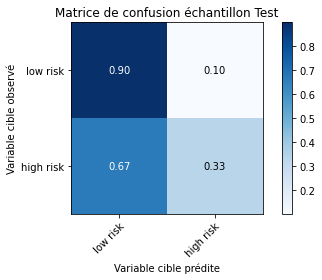

In [39]:
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, pred_test, classes=["low risk","high risk"], 
                      title='Matrice de confusion échantillon Test')

### métrics basées sur un cutoff :
la métrique est calculable si le modèle a déjà pris une décision (au dela d'un cutoff entre 0 et 1, je prédis 1)

Le recall est le poids de positifs bien prédits (true positive rate) , il exprime la couverture du phénomène
accuracy est le taux de bien classés
Sensibilité = Recall (capture) = ‟% d’event 1 (pos) bien prédit” = Vrais Positifs / Positif Observés

La Precision = taux de vrais positifs parmi les positifs prédits, une précision faible signifie qu’on génère beaucoup de faux positifs
Précision = Vrais Positifs /Positifs prédits = poids des biens prédits dans les prédits

In [40]:
# dans y_pred il doit y avoir 0/1 pas une proba
from sklearn.metrics import f1_score,recall_score,log_loss,accuracy_score, precision_score
print("f1",f1_score(y_test, pred_test) ,"recall",recall_score(y_test, pred_test),"precision",precision_score(y_test, pred_test) ,"accuracy",accuracy_score(y_test, pred_test) )

f1 0.4081632653061224 recall 0.3333333333333333 precision 0.5263157894736842 accuracy 0.7563025210084033


In [41]:
print(accuracy_score(y_train, pred_train),accuracy_score(y_test, modele_arbre2.predict(X_test)))

0.7971014492753623 0.7563025210084033


### métrics quantités qui ne dépendent pas d'un cutoff :
la métrique est calculable à partir des probas/scores

On peut tracer ainsi la courbe ROC : en abscisse le taux de faux positifs et en ordonnée le taux de vrai positif

La courbe montre que lorsque le recall est bon (proche 1),
1- spécificité est proche de 1 ce qui signifie que plus on capture d’évènements positif (bon recall),
plus on en prédit et plus on crée de faux positifs (1-spécificité)
ROC AUC : area under curve est l’aire sous la courbe entre compris entre 0,5 et  1



LA fonction logLoss est une métrique alternative qui exprime la quantité d’erreur produite par le modèle, 
elle est très utilisée car elle mesure l’erreur en pénalisant les obs très mal classées 
(probabilité de la classe réelle très faible)



In [42]:
# Récupérer les probas pour pouvoir calculer les métriques threshold invariant
proba_train=modele_arbre2.predict_proba(X_train)[:,1]
proba_test=modele_arbre2.predict_proba(X_test)[:,1]
proba_train.mean()

0.26811594202898553

In [43]:
#Log loss, aka logistic loss or cross-entropy loss.
print("logloss Train:",log_loss(y_train,proba_train),"logloss Test:",log_loss(y_test,proba_test))

logloss Train: 0.4590391609689845 logloss Test: 0.6180640684118307


In [44]:
# métrics non basés surun cut off
from sklearn.metrics import roc_auc_score,roc_curve,average_precision_score
# AUC
print("Roc AUC Train:",roc_auc_score(y_train,proba_train),"Roc AUC Test:",roc_auc_score(y_test,proba_test))

Roc AUC Train: 0.7871956114530372 Roc AUC Test: 0.5764044943820225


In [45]:
# a precision-recall curve as the weighted mean of precisions achieved at each threshold,
print("average prec Train:",average_precision_score(y_train,proba_train),"average prec  Test:",average_precision_score(y_test,proba_test))

average prec Train: 0.5372059652577076 average prec  Test: 0.35515381591232986


Tracons la courbe ROC

In [ ]:
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y_test, proba_test)
roc_auc = auc(fpr, tpr) # calcul AUC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Modèle de régression logistique pénalisée

Une régression pénalisée de type ridge (L2) permet de contraindre l'espace des coef estimés pour ne pas qu'ils prennent des valeurs contradictoires et très élevées,
Si la régression est de type lasso (L1) alors certains coefficients vont être annulés.
Le paramètre C contrôle cela : 
C = Inverse of regularization strength; must be a positive float = smaller values specify stronger regularization.

A noter que dans certaines classes, le paramètre est 1/C

Tester plusieurs valeurs de C inf à 1 et regardez l'impact sur les coefficients

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)  # normalise l’éch d’apprentissage

StandardScaler(copy=True, with_mean=True, with_std=True)

In [48]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)  # applique à l’éch test


In [49]:
type(X_train)

numpy.ndarray

In [51]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
# on récupère les noms de col
X_train.columns = X.columns
X_test.columns = X.columns

In [52]:
# régression lasso
from sklearn.linear_model import LogisticRegression
student_classifier_logreg = LogisticRegression(penalty='l1',
                                               tol=0.0001, C=0.1, fit_intercept=True,
                                               solver='liblinear',
                                               class_weight=None,max_iter=100)


In [53]:
student_classifier_logreg.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
coef=list(student_classifier_logreg.coef_[0])
len(coef)

36

In [42]:
print(pd.DataFrame({'Coefficients': list(coef)}, list(X_train.columns.values)))

                   Coefficients
age                    0.000000
Medu                   0.000000
Fedu                   0.000000
traveltime             0.000000
studytime             -0.012590
failures               0.070297
famrel                -0.007687
freetime               0.043131
goout                  0.457503
health                 0.000000
school_MS              0.000000
gender_M               0.212852
famsize_LE3            0.000000
address_U             -0.152663
Pstatus_T              0.000000
Mjob_health            0.000000
Mjob_other             0.000000
Mjob_services          0.000000
Mjob_teacher           0.000000
Fjob_health            0.000000
Fjob_other             0.000000
Fjob_services          0.022465
Fjob_teacher           0.000000
reason_home            0.000000
reason_other           0.194521
reason_reputation      0.000000
guardian_mother        0.000000
guardian_other         0.000000
schoolsup_yes          0.000000
famsup_yes             0.000000
paid_yes

In [57]:
student_classifier_logreg = LogisticRegression(penalty='l1',
                                               tol=0.0001, C=0.5, fit_intercept=True,
                                               solver='liblinear',
                                               class_weight=None,max_iter=1000)
student_classifier_logreg.fit(X_train, y_train)
coef=list(student_classifier_logreg.coef_[0])
print(pd.DataFrame({'Coefficients': list(coef)}, list(X_train.columns.values)))

                   Coefficients
age                   -0.062578
Medu                   0.009933
Fedu                   0.000000
traveltime             0.000000
studytime             -0.117306
failures               0.150704
famrel                -0.310356
freetime               0.298984
goout                  1.122587
health                 0.026043
school_MS             -0.046668
gender_M               0.244361
famsize_LE3            0.074605
address_U             -0.227478
Pstatus_T             -0.005958
Mjob_health           -0.010794
Mjob_other             0.027098
Mjob_services         -0.080320
Mjob_teacher          -0.015708
Fjob_health           -0.012515
Fjob_other             0.114604
Fjob_services          0.147681
Fjob_teacher          -0.025495
reason_home            0.068502
reason_other           0.128041
reason_reputation     -0.020682
guardian_mother       -0.103177
guardian_other         0.000000
schoolsup_yes          0.094110
famsup_yes             0.000000
paid_yes

In [58]:
# Récupérer les probas pour pouvoir calculer les métriques threshold invariant
proba_train=student_classifier_logreg.predict_proba(X_train)[:,1]
proba_test=student_classifier_logreg.predict_proba(X_test)[:,1]
proba_train.mean()

0.2681397112521682

In [59]:
print("Roc AUC Train:",roc_auc_score(y_train,proba_train),"Roc AUC Test:",roc_auc_score(y_test,proba_test))
print("logloss Train:",log_loss(y_train,proba_train),"logloss Test:",log_loss(y_test,proba_test))

Roc AUC Train: 0.8584426010168584 Roc AUC Test: 0.6966292134831462
logloss Train: 0.39029304570467976 logloss Test: 0.5649369102833637


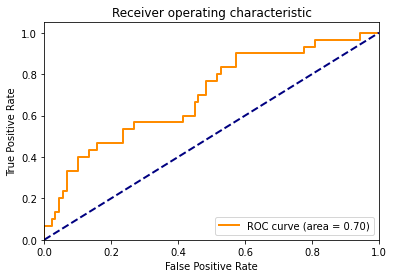

In [60]:
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(y_test, proba_test)
roc_auc = auc(fpr, tpr) # calcul AUC
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [62]:
# La grille
param = [{ "C": [0.01,0.025,0.05,0.1]}]
lr=LogisticRegression(penalty='l1',fit_intercept=True,solver='liblinear',class_weight=None,max_iter=100)
# on declare le modele DecisionTreeClassifier sur lequel par cross validation on va balayer la grille
#tree= GridSearchCV(DecisionTreeClassifier(), param, cv = 4, n_jobs = -1, scoring='roc_auc')
modelCV= GridSearchCV(lr, param, cv = 4, n_jobs = -1, scoring='neg_log_loss')

modelCV = modelCV.fit(X_train, y_train)

In [63]:
modelCV.best_params_

{'C': 0.1}

In [66]:
student[featuresquanti].corr(method='pearson')

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health
age,1.000000,-0.163658,-0.163438,0.070641,-0.004140,0.243665,0.053940,0.016434,0.126964,-0.062187
Medu,-0.163658,1.000000,0.623455,-0.171639,0.064944,-0.236680,-0.003914,0.030891,0.064094,-0.046878
Fedu,-0.163438,0.623455,1.000000,-0.158194,-0.009175,-0.250408,-0.001370,-0.012846,0.043105,0.014742
traveltime,0.070641,-0.171639,-0.158194,1.000000,-0.100909,0.092239,-0.016808,-0.017025,0.028540,0.007501
studytime,-0.004140,0.064944,-0.009175,-0.100909,1.000000,-0.173563,0.039731,-0.143198,-0.063904,-0.075616
failures,0.243665,-0.236680,-0.250408,0.092239,-0.173563,1.000000,-0.044337,0.091987,0.124561,0.065827
famrel,0.053940,-0.003914,-0.001370,-0.016808,0.039731,-0.044337,1.000000,0.150701,0.064568,0.094056
freetime,0.016434,0.030891,-0.012846,-0.017025,-0.143198,0.091987,0.150701,1.000000,0.285019,0.075733
goout,0.126964,0.064094,0.043105,0.028540,-0.063904,0.124561,0.064568,0.285019,1.000000,-0.009577
health,-0.062187,-0.046878,0.014742,0.007501,-0.075616,0.065827,0.094056,0.075733,-0.009577,1.000000
